<a href="https://colab.research.google.com/github/parnian91/Language_Modelling/blob/main/Language_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  <font color='#FFE15D'><b>💎 Project : Language Modeling 🎼</b></font>


# 🔴 **Environment Setup**

In [ ]:
!pip install -q torchmetrics

In [ ]:
!pip install -q portalocker>=2.0.0

# 🔴 **Import Libs**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torchtext
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

from collections import Counter

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
torch --> 2.1.0+cu121
torchtext --> 0.16.0+cpu
tqdm --> 4.66.1


# 🔴 **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

In [ ]:
train_iter, valid_iter, test_iter = WikiText2('/content/')

In [ ]:
train_iter

ShardingFilterIterDataPipe

In [ ]:
#class CustomDataset(IterableDataset):

#  def __init__(self):
#    pass

#  def __iter__(self):
#    pass

In [ ]:
train_iter_ = iter(train_iter)
train_iter_

<generator object ShardingFilterIterDataPipe.__iter__ at 0x7db53d0d4c80>

In [ ]:
next(train_iter_)

' \n'

## 🟠 Build vocabulary and save it

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [ ]:
txt = ['@sajad hi sajad! 1 n2 3 #45', 'how are are you?']
tokenizer = get_tokenizer('basic_english')
[tokenizer(line) for line in txt]
list(map(tokenizer, txt))

[['@sajad', 'hi', 'sajad', '!', '1', 'n2', '3', '#45'],
 ['how', 'are', 'are', 'you', '?']]

In [ ]:
vocab = build_vocab_from_iterator(map(tokenizer, txt) , specials=['<ukn>'])
vocab.set_default_index(vocab['<ukn>'])
vocab.get_stoi()

{'sajad': 11,
 'n2': 10,
 'how': 9,
 'you': 12,
 'hi': 8,
 '@sajad': 7,
 '?': 6,
 '3': 5,
 '1': 4,
 '#45': 3,
 '!': 2,
 'are': 1,
 '<ukn>': 0}

In [ ]:
vocab(['hi'])

[8]

In [ ]:
vocab(['hi', 'sajad', '<ukn>'])

[8, 11, 0]

In [ ]:
vocab(['hi', 'sajad', '<ukn>', 'hello'])

[8, 11, 0, 0]

In [ ]:
vocab(['hi', 'sajad', '<ukn>', 'hello', 'Hi'.lower()])

[8, 11, 0, 0, 8]

In [ ]:
vocab = build_vocab_from_iterator(map(tokenizer, txt), specials=['<ukn>'], min_freq=2)
vocab.set_default_index(vocab['<ukn>'])
vocab.get_stoi()

{'are': 1, '<ukn>': 0}

# --------------------------------------------------

In [ ]:
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [ ]:
len(vocab)

28782

In [ ]:
vocab['salam']

22952

In [ ]:
#vocab.get_stoi()

In [ ]:
torch.save(vocab, 'vocab.pt')

## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

In [ ]:
total_sentence_count = 0
total_sentence_length = 0

for line in train_iter:
    sentences = line.split('.')

    for sentence in sentences:
        tokens = sentence.strip().split()
        sentence_length = len(tokens)

        if sentence_length > 0:
            total_sentence_count += 1
            total_sentence_length += sentence_length

mean_sentence_length = total_sentence_length / total_sentence_count

print(f'Mean sentence length in Wikitext-2: {mean_sentence_length:.2f}')

Mean sentence length in Wikitext-2: 21.69


### 🟡 Analyze the most common and least common words in the dataset.

In [ ]:
freqs = Counter([1, 2, 2, 3, 2, 3])
freqs

Counter({1: 1, 2: 3, 3: 2})

In [ ]:
freqs = Counter()
for tokens in map(tokenizer, train_iter):
  freqs.update(tokens)

In [ ]:
freqs.most_common()

[('the', 130768),
 (',', 102615),
 ('.', 83397),
 ('of', 57030),
 ('<unk>', 54625),
 ('and', 50735),
 ('in', 45015),
 ('to', 39521),
 ('a', 36523),
 ('=', 29570),
 ('was', 21008),
 ("'", 18484),
 ('@-@', 16906),
 ('on', 15140),
 ('as', 15058),
 ('s', 14936),
 ('that', 14351),
 ('for', 13794),
 ('with', 13012),
 ('by', 12718),
 (')', 12004),
 ('(', 11992),
 ('@', 11786),
 ('is', 11691),
 ('it', 9273),
 ('from', 9229),
 ('at', 9070),
 ('his', 9019),
 ('he', 8706),
 ('were', 7334),
 ('an', 6250),
 ('had', 5707),
 ('which', 5546),
 ('be', 4859),
 ('are', 4714),
 ('this', 4560),
 ('their', 4290),
 ('first', 4242),
 ('but', 4233),
 ('not', 4006),
 ('–', 3934),
 ('one', 3910),
 ('they', 3894),
 ('its', 3877),
 ('also', 3842),
 ('after', 3749),
 ('her', 3670),
 ('or', 3655),
 ('two', 3565),
 ('have', 3470),
 ('has', 3325),
 ('been', 3263),
 ('who', 3029),
 ('she', 2884),
 ('new', 2767),
 ('other', 2729),
 ('during', 2690),
 ('when', 2655),
 ('time', 2607),
 ('all', 2557),
 ('into', 2443),
 ('m

In [ ]:
freqs.most_common()[-6000:]

[('refreshing', 4),
 ('aback', 4),
 ('uproar', 4),
 ('novi', 4),
 ('mshd', 4),
 ('881', 4),
 ('ibrahima', 4),
 ('1726', 4),
 ('mandé', 4),
 ('yalunka', 4),
 ('bundu', 4),
 ('almami', 4),
 ('donnel', 4),
 ('cctv', 4),
 ('fiancée', 4),
 ('fibres', 4),
 ('calmly', 4),
 ('gaviria', 4),
 ('andes', 4),
 ('stylized', 4),
 ('40th', 4),
 ('zurich', 4),
 ('rafa', 4),
 ('jonas', 4),
 ('mcenroe', 4),
 ('tiebreaker', 4),
 ('borg', 4),
 ('racquets', 4),
 ('battled', 4),
 ('tiebreak', 4),
 ('surpass', 4),
 ('prolonging', 4),
 ('baseline', 4),
 ('forehand', 4),
 ('dogfights', 4),
 ('simulators', 4),
 ('graphical', 4),
 ('hantzopoulos', 4),
 ('gauges', 4),
 ('itcz', 4),
 ('accelerating', 4),
 ('mudskippers', 4),
 ('tasting', 4),
 ('bbdo', 4),
 ('squirrels', 4),
 ('mustang', 4),
 ('overlapped', 4),
 ('stella', 4),
 ('mulhall', 4),
 ('windass', 4),
 ('oblivion', 4),
 ('californicus', 4),
 ('diets', 4),
 ('rabbits', 4),
 ('mites', 4),
 ('hares', 4),
 ('sonora', 4),
 ('wheatgrass', 4),
 ('coyote', 4),
 ('l

## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [ ]:
a = [vocab(tokenizer(line)) for line in train_iter]
b = [line for line in train_iter]
a[1], b[1]

([9, 3849, 3869, 881, 9], ' = Valkyria Chronicles III = \n')

In [ ]:
def data_process(raw_text_iter, seq_len):
  data = torch.cat([torch.LongTensor(vocab(tokenizer(line))) for line in raw_text_iter])

  M = len(data) // seq_len

  r = len(data) % seq_len
  data = torch.cat((data, torch.LongTensor([0]))) if r==0 else data

  inputs = data[:M*seq_len]
  inputs = inputs.reshape(-1, seq_len)

  targets = data[1:M*seq_len+1]
  targets = targets.reshape(-1, seq_len)

  return inputs, targets

In [ ]:
seq_len = 35

X_train, y_train = data_process(train_iter, seq_len)
X_valid, y_valid = data_process(valid_iter, seq_len)
X_test, y_test = data_process(test_iter, seq_len)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

(torch.Size([58571, 35]),
 torch.Size([58571, 35]),
 torch.Size([6126, 35]),
 torch.Size([6126, 35]),
 torch.Size([6910, 35]),
 torch.Size([6910, 35]))

## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

In [ ]:
class LanguageModelDataset(Dataset):

  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]

In [ ]:
train_set = LanguageModelDataset(X_train, y_train)
valid_set = LanguageModelDataset(X_valid, y_valid)
test_set = LanguageModelDataset(X_test, y_test)

In [ ]:
train_set[0]

(tensor([    9,  3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,
          3869,    21,   780, 28780,     2,  6182,     3,  3849,     4,     1,
          5023,    88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,
           881,   629,   976,     2,    23]),
 tensor([ 3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,  3869,
            21,   780, 28780,     2,  6182,     3,  3849,     4,     1,  5023,
            88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,   881,
           629,   976,     2,    23,     8]))

## 🟠 Define a dataloader if needed

🔰 Write dataloaders for the training, validation, and test sets.

In [ ]:
batch_size = 20

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([20, 35]), torch.Size([20, 35]))

# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [ ]:
class LanguageModel(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
                dropout_embd=0.5, dropout_rnn=0.5):
    super().__init__()
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim
    self.embedding_dim = embedding_dim

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight.data.uniform_(-0.1, 0.1)
    self.dropout = nn.Dropout(p=dropout_embd)

    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                        dropout=dropout_rnn, batch_first=True)

    self.fc = nn.Linear(hidden_dim, vocab_size)

  def forward(self, src):
    embedding = self.dropout(self.embedding(src))
    output, hidden = self.lstm(embedding)
    prediction = self.fc(output)
    return prediction

In [ ]:
model = LanguageModel(vocab_size=len(vocab),
                      embedding_dim=300,
                      hidden_dim=512,
                      num_layers=2,
                      dropout_embd=0.65,
                      dropout_rnn=0.5)
model

LanguageModel(
  (embedding): Embedding(28782, 300)
  (dropout): Dropout(p=0.65, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=28782, bias=True)
)

In [ ]:
model(x_batch).shape

torch.Size([20, 35, 28782])

In [ ]:
num_trainable_params(model.embedding), num_trainable_params(model.lstm), num_trainable_params(model.fc)

(8.6346, 3.76832, 14.765166)

# 🔴 **Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 512
num_layers = 2
dropout_embd = 0.5
dropout_rnn = 0.2

model = LanguageModel(vocab_size, embedding_dim,
                      hidden_dim, num_layers,
                      dropout_embd, dropout_rnn).to(device)

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.5, weight_decay=0, momentum=0.9, nesterov=True)

loss_fn = nn.CrossEntropyLoss()

metric = tm.text.Perplexity().to(device)

In [ ]:
clip = 0.25

# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

      loss.backward()

      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm=clip)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.

In [ ]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

print(loss)

tensor(10.2694, device='cuda:0')


In [ ]:
outputs.reshape(-1, outputs.shape[-1]).shape, targets.flatten().shape

(torch.Size([700, 28782]), torch.Size([700]))

In [ ]:
torch.cuda.empty_cache()

### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.9, momentum=0.9)

In [ ]:
mini_train_size = 1000
_, mini_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, epoch)

Epoch 99: 100%|██████████| 50/50 [00:01<00:00, 26.51batch/s, loss=0.283, metric=1.33]


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs = 3

for lr in [2, 0.9, 0.5, 0.3, 0.09, 0.05]:
  print(f'LR={lr}')

  model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)
  model = torch.load('/content/model.pt')

  # optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0, momentum=0.9)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-6, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

LR=2


Epoch 2: 100%|██████████| 2929/2929 [01:55<00:00, 25.41batch/s, loss=4.98, metric=146]



LR=0.9


Epoch 2: 100%|██████████| 2929/2929 [01:55<00:00, 25.43batch/s, loss=5.21, metric=183]



LR=0.5


Epoch 2: 100%|██████████| 2929/2929 [01:54<00:00, 25.50batch/s, loss=5.5, metric=246]



LR=0.3


Epoch 2: 100%|██████████| 2929/2929 [01:55<00:00, 25.31batch/s, loss=5.77, metric=320]



LR=0.09


Epoch 2: 100%|██████████| 2929/2929 [01:55<00:00, 25.29batch/s, loss=6.42, metric=616]



LR=0.05


Epoch 2:  88%|████████▊ | 2592/2929 [01:41<00:13, 25.80batch/s, loss=6.83, metric=927]

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.


In [ ]:
num_epochs = 1

for lr in [3.]:
  for wd in [1e-6, 1e-4, 1e-5]:
    print(f'LR={lr}, WD={wd}')

    model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

    for epoch in range(num_epochs):
      model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

    print()

LR=3.0, WD=1e-06


100%|██████████| 2929/2929 [01:51<00:00, 26.16batch/s, loss=5.88, metric=358]



LR=3.0, WD=0.0001


100%|██████████| 2929/2929 [01:51<00:00, 26.27batch/s, loss=6.27, metric=527]



LR=3.0, WD=1e-05


100%|██████████| 2929/2929 [01:51<00:00, 26.38batch/s, loss=5.92, metric=372]

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.

In [ ]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.5).to(device)

In [ ]:
lr = 0.05
wd = 1e-6
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 15

for epoch in range(1, num_epochs+1):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 1: 100%|██████████| 2929/2929 [01:59<00:00, 24.42batch/s, loss=5.82, metric=336]


Model Saved!
Valid: Loss = 5.623, Metric = 276.6



Epoch 2: 100%|██████████| 2929/2929 [01:57<00:00, 24.91batch/s, loss=5.77, metric=320]


Model Saved!
Valid: Loss = 5.593, Metric = 268.5



Epoch 3: 100%|██████████| 2929/2929 [01:55<00:00, 25.31batch/s, loss=5.73, metric=308]


Model Saved!
Valid: Loss = 5.562, Metric = 260.3



Epoch 4: 100%|██████████| 2929/2929 [01:55<00:00, 25.30batch/s, loss=5.69, metric=297]


Model Saved!
Valid: Loss = 5.536, Metric = 253.7



Epoch 5: 100%|██████████| 2929/2929 [01:55<00:00, 25.27batch/s, loss=5.66, metric=287]


Model Saved!
Valid: Loss = 5.514, Metric = 248.1



Epoch 6: 100%|██████████| 2929/2929 [01:55<00:00, 25.40batch/s, loss=5.63, metric=279]


Model Saved!
Valid: Loss = 5.493, Metric = 242.9



Epoch 7: 100%|██████████| 2929/2929 [01:56<00:00, 25.10batch/s, loss=5.6, metric=271]


Model Saved!
Valid: Loss = 5.475, Metric = 238.5



Epoch 8: 100%|██████████| 2929/2929 [01:56<00:00, 25.25batch/s, loss=5.57, metric=263]


Model Saved!
Valid: Loss = 5.451, Metric = 233.0



Epoch 9: 100%|██████████| 2929/2929 [01:55<00:00, 25.29batch/s, loss=5.55, metric=256]


Model Saved!
Valid: Loss = 5.432, Metric = 228.6



Epoch 10: 100%|██████████| 2929/2929 [01:55<00:00, 25.32batch/s, loss=5.52, metric=250]


Model Saved!
Valid: Loss = 5.419, Metric = 225.6



Epoch 11: 100%|██████████| 2929/2929 [01:58<00:00, 24.64batch/s, loss=5.5, metric=244]


Model Saved!
Valid: Loss = 5.397, Metric = 220.8



Epoch 12: 100%|██████████| 2929/2929 [01:55<00:00, 25.29batch/s, loss=5.47, metric=238]


Model Saved!
Valid: Loss = 5.383, Metric = 217.6



Epoch 13: 100%|██████████| 2929/2929 [01:55<00:00, 25.39batch/s, loss=5.45, metric=233]


Model Saved!
Valid: Loss = 5.362, Metric = 213.2



Epoch 14: 100%|██████████| 2929/2929 [01:55<00:00, 25.39batch/s, loss=5.43, metric=228]


Model Saved!
Valid: Loss = 5.351, Metric = 210.8



Epoch 15: 100%|██████████| 2929/2929 [01:55<00:00, 25.42batch/s, loss=5.41, metric=223]


Model Saved!
Valid: Loss = 5.343, Metric = 209.1



## 🟠 Plot

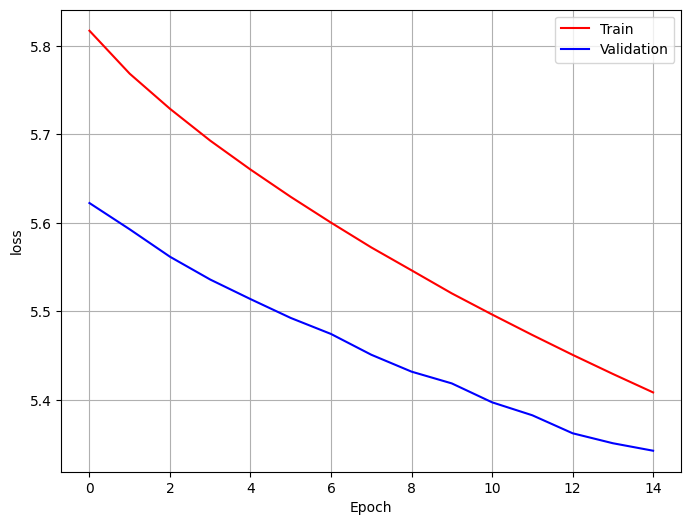

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 🟠 Main Loop

In [ ]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

In [ ]:
lr = 3
wd = 1e-6
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 12

for epoch in range(1, num_epochs+1):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 1: 100%|██████████| 2929/2929 [01:55<00:00, 25.37batch/s, loss=5.89, metric=361]


Model Saved!
Valid: Loss = 5.33, Metric = 206.5



Epoch 2: 100%|██████████| 2929/2929 [01:57<00:00, 24.82batch/s, loss=5.25, metric=190]


Model Saved!
Valid: Loss = 5.103, Metric = 164.5



Epoch 3: 100%|██████████| 2929/2929 [01:55<00:00, 25.28batch/s, loss=4.97, metric=144]


Model Saved!
Valid: Loss = 5.024, Metric = 151.9



Epoch 4: 100%|██████████| 2929/2929 [01:55<00:00, 25.35batch/s, loss=4.79, metric=120]


Model Saved!
Valid: Loss = 4.969, Metric = 143.9



Epoch 5: 100%|██████████| 2929/2929 [01:55<00:00, 25.28batch/s, loss=4.66, metric=106]


Model Saved!
Valid: Loss = 4.964, Metric = 143.2



Epoch 6: 100%|██████████| 2929/2929 [01:56<00:00, 25.18batch/s, loss=4.56, metric=95.9]


Valid: Loss = 4.964, Metric = 143.2



Epoch 7: 100%|██████████| 2929/2929 [01:56<00:00, 25.18batch/s, loss=4.48, metric=88.6]


Model Saved!
Valid: Loss = 4.958, Metric = 142.2



Epoch 8: 100%|██████████| 2929/2929 [01:59<00:00, 24.46batch/s, loss=4.42, metric=83.1]


Valid: Loss = 4.97, Metric = 144.0



Epoch 9: 100%|██████████| 2929/2929 [01:57<00:00, 25.02batch/s, loss=4.37, metric=78.7]


Valid: Loss = 4.966, Metric = 143.5



Epoch 10: 100%|██████████| 2929/2929 [01:59<00:00, 24.44batch/s, loss=4.32, metric=75.2]


Valid: Loss = 4.977, Metric = 145.0



Epoch 11: 100%|██████████| 2929/2929 [01:57<00:00, 25.03batch/s, loss=4.28, metric=72.2]


Valid: Loss = 5.004, Metric = 149.1



Epoch 12: 100%|██████████| 2929/2929 [01:55<00:00, 25.26batch/s, loss=4.24, metric=69.8]


Valid: Loss = 4.987, Metric = 146.5



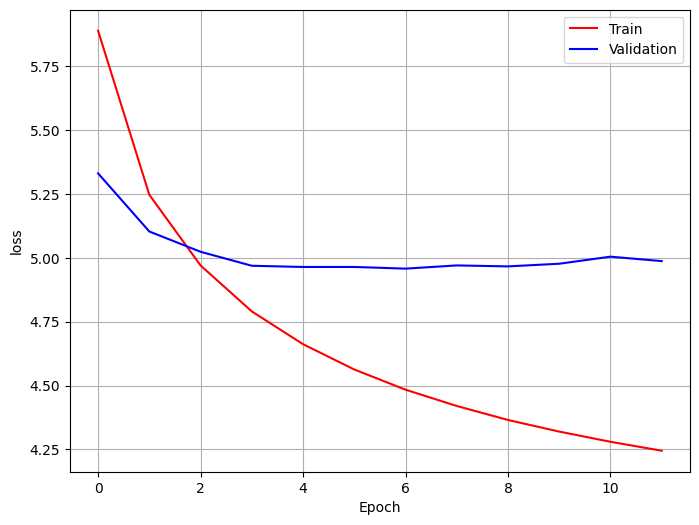

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

In [ ]:
model_path = '/content/model.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embedding): Embedding(28782, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=512, out_features=28782, bias=True)
)

In [ ]:
loss_valid, metric_valid = evaluate(model, valid_loader, loss_fn, metric)
metric_valid

142.24684143066406

In [ ]:
loss_test, metric_test = evaluate(model, test_loader, loss_fn, metric)
metric_test

135.1143798828125

# 🔴 **Generate**

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embedding): Embedding(28782, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=512, out_features=28782, bias=True)
)

In [ ]:
prompt = 'In a galaxy far, far away, there'

indices = vocab(tokenizer(prompt))
itos = vocab.get_itos()

max_seq_len = 35
for i in range(max_seq_len):
  src = torch.LongTensor(indices).to(device)

  with torch.no_grad():
    prediction = model(src)

  # Method 1
  # idx = torch.argmax(prediction[-1])
  # itos = vocab.get_itos()
  # itos[idx]

  # Method 2
  temperature = 0.5
  probs = torch.softmax(prediction[-1]/temperature, dim=0)

  idx = vocab['<ukn>']
  while idx == vocab['<ukn>']:
    idx = torch.multinomial(probs, num_samples=1).item()

  token = itos[idx]
  prompt += ' ' + token

  if idx == vocab['.']:
    break

  indices.append(idx)

print(prompt)

In a galaxy far, far away, there were several other sightings , and the other few homes were recorded .


In [ ]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
  if seed is not None:
    torch.manual_seed(seed)

  indices = vocab(tokenizer(prompt))
  itos = vocab.get_itos()

  for i in range(max_seq_len):
    src = torch.LongTensor(indices).to(device)

    with torch.no_grad():
      prediction = model(src)

    # Method 1
    # idx = torch.argmax(prediction[-1])
    # itos = vocab.get_itos()
    # itos[idx]

    # Method 2
    probs = torch.softmax(prediction[-1]/temperature, dim=0)

    idx = vocab['<ukn>']
    while idx == vocab['<ukn>']:
      idx = torch.multinomial(probs, num_samples=1).item()

    token = itos[idx]
    prompt += ' ' + token

    if idx == vocab['.']:
      return prompt

    indices.append(idx)

  return prompt

In [ ]:
prompt = 'In a galaxy far, far away, there'
generate(prompt, 35, 0.5, model, tokenizer, vocab)

'In a galaxy far, far away, there are two separate species species in the genus .'

In [ ]:

prompt = 'The sun was setting in the'
generate(prompt, 35, 0.5, model, tokenizer, vocab)

'The sun was setting in the bone marrow .'

In [ ]:
prompt = 'Once upon a time, there lived a young princess named'
prompt = 'What is the meaning '
prompt = 'What is the name '
generate(prompt, 35, 0.5, model, tokenizer, vocab)

'What is the name  of the word .'